# Image Classification Using ConvNets

We will implement a Convolutional Neural Net from scratch to perform image classification. Many proven implementations of this ML model already exist and are available through free libraries such as tensorflow, pytorch etc. However we will not rely on these and instead build our own, to improve our understanding of what really is happening inside of the black box.

### Dataset

We will be working with [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist): a dataset containing 28x28 grayscale images of clothing articles. Although having the same type of input and range of labels, Fashion-MNIST is an alternative which is more challenging and better yet: more representative of modern image recognition problems; compared to the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) we all know and love.

To download the dataset:

In [1]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P data

^C


--2022-11-13 15:58:53--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.70
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29515 (29K) [binary/octet-stream]
Saving to: 'data/train-labels-idx1-ubyte.gz.3'

     0K .......... .......... ........                        100%  285K=0.1s

2022-11-13 15:58:54 (285 KB/s) - 'data/train-labels-idx1-ubyte.gz.3' saved [29515/29515]

--2022-11-13 15:58:41--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.169.84
Connecting to fashion-mnist.s3-website.eu-central-1.amaz

After doing this, make sure to unzip the tarballs in order

### Imports

In [1]:
import matplotlib.pyplot as plt
import mnist
import numpy as np
import random
import os

## Understanding the data

In [2]:
mndata = mnist.MNIST('data')

images_train, labels_train = mndata.load_training()
images_test, labels_test = mndata.load_testing()

In [3]:
X_train = np.array(images_train, dtype=np.float64)
X_test = np.array(images_test, dtype=np.float64)
Y_train = np.array(labels_train, dtype=np.uint8)
Y_test = np.array(labels_test, dtype=np.uint8)

In [4]:
print(X_train.shape, X_train.dtype)
print(Y_train.shape, Y_train.dtype)
print(X_test.shape)
print(Y_test.shape)

(60000, 784) float64
(60000,) uint8
(10000, 784)
(10000,)


We have 60000 training examples and 10000 testing examples. Each of these is a list of 784 numbers which represent each of the 28x28 pixels in the image. The value of the number represents how black the pixel is.

In [5]:
label_to_article_map= {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

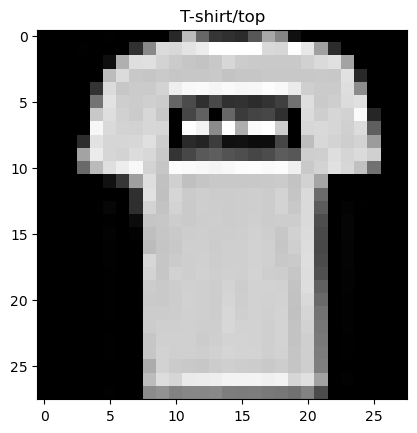

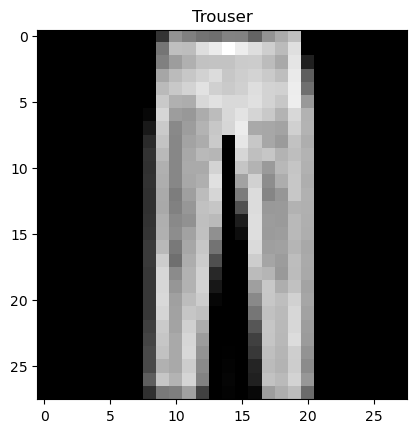

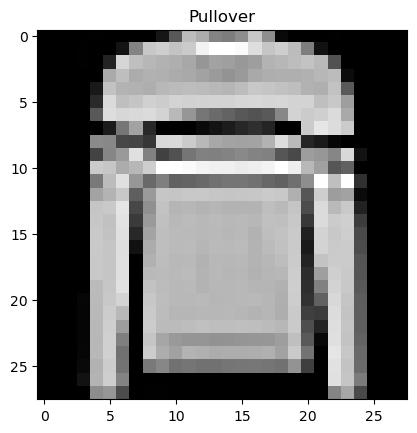

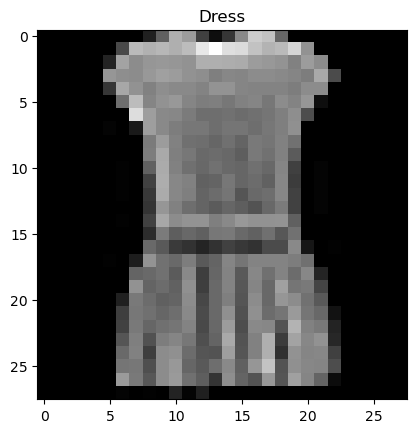

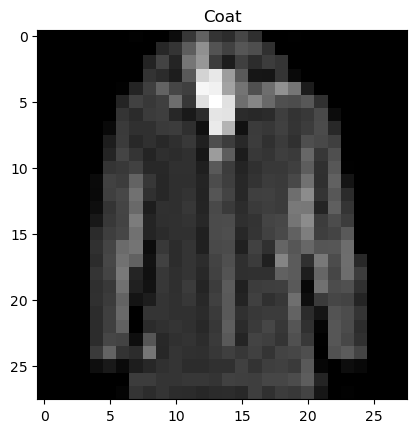

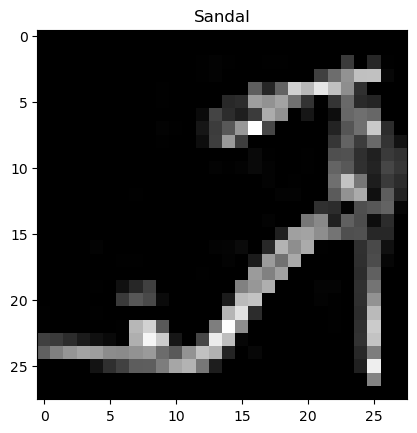

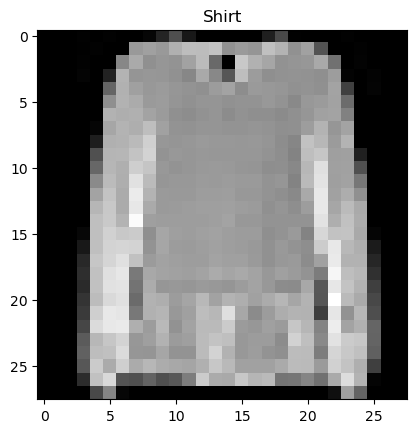

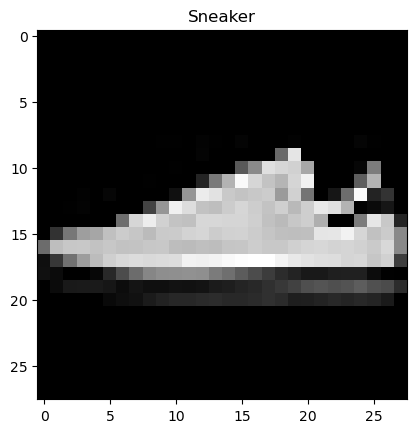

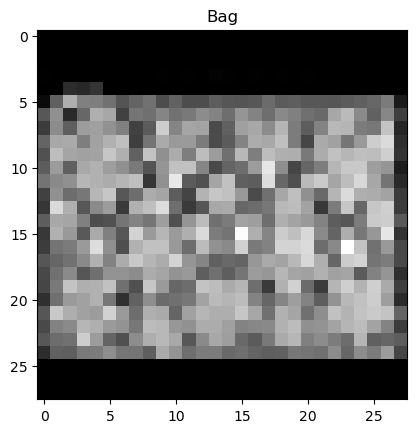

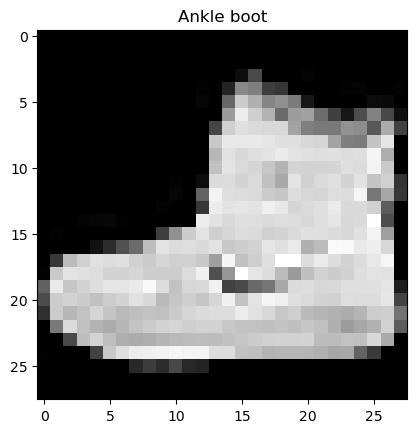

In [6]:
def display_image(index, train=True):
    if train:
        image = X_train[index]
        label = Y_train[index]
    else:
        image = X_test[index]
        label = Y_train[index]

    image = np.array(image, dtype='float')
    pixels = image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(f"{label_to_article_map[label]}")
    plt.show()

#We display one image of each type.
for j in range(0, 10):
    for i in range(0, len(X_train)):
        if Y_train[i] == j:
            display_image(i)
            break

### Standardization

We will now standardize the data by pulling the mean to the center and adjusting the scale.

In [7]:
print(np.mean(X_test))
print(np.mean(X_train))

73.14656658163265
72.94035223214286


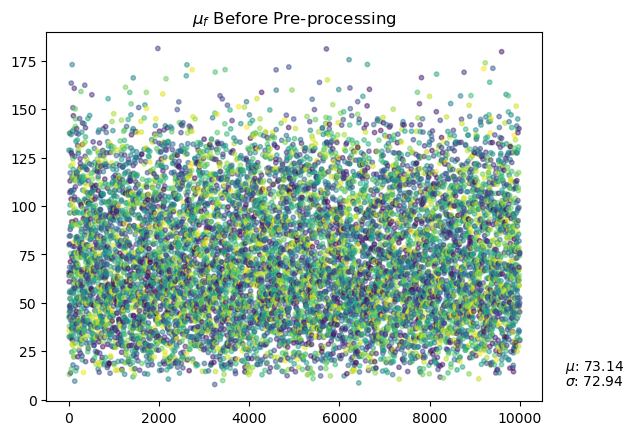

In [8]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ Before Pre-processing")
plt.text(11000, 15, r"$\mu$: 73.14")
plt.text(11000, 7.5, r"$\sigma$: 72.94")
plt.show()

In [9]:
# Centering
X_train -= np.mean(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)

# Normalization
X_train /= np.std(X_train, axis = 0)
X_test /= np.std(X_test, axis = 0)

In [10]:
print(np.mean(X_test))
print(np.mean(X_train))

-1.3050784942532453e-19
4.0602442043434296e-19


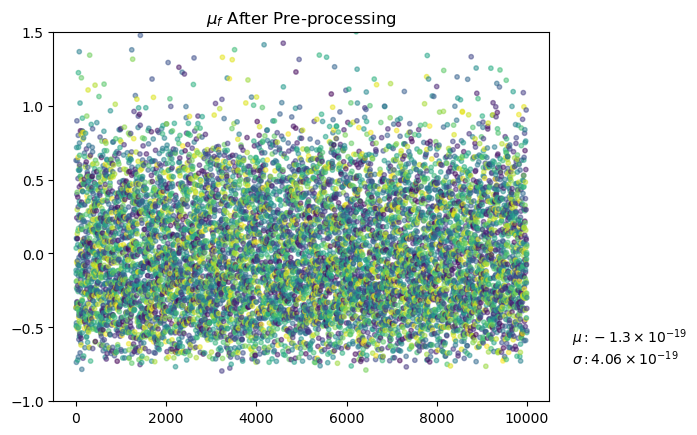

In [11]:
plt.scatter(np.arange(0, len(X_test)), list(map(np.mean, X_test)),  s=10,  alpha=.5, c = np.random.rand(X_test.shape[0]))
plt.title(r"$\mu_f$ After Pre-processing")
plt.text(11000, -.6, r"$\mu: -1.3 \times 10^{-19}$")
plt.text(11000, -.75, r"$\sigma: 4.06 \times 10^{-19}$")
plt.ylim(-1, 1.5)
plt.show()

We've effectively reduced the mean and standard deviation to approximately 0.

## Multi-layer Perceptron

We now code out a standard multi-layer perceptron which we will train using back propagation combined with stochastic gradient descent. The following notations are largely from chapter 20.6 of Shalev-Shwartz and Ben-David's textbook "Understanding Machine Learning: From Theory to Algorithms". We will strictly follow them in implementation. The code below uses https://colab.research.google.com/github/yueliyl/comp551-notebooks/blob/master/NumpyDeepMLP.ipynb#scrollTo=WmWczKeXrTE6 as a starting point.

By a <b>multi-layer perceptron</b>, we mean a edge weighted finite graph $G$ organized in the following manner:

1. There exists a positive integer $T$ such that $V(G)$ is partitioned by sets $V_0, V_1, \cdots, V_T$. These sets are called <b>layers</b>. $V_0$ is the <b>input layer</b>, $V_T$ is the <b>output layer:</b>, and the rest are called the <b>hidden layers</b>. For our purpose, we assume there is an edge between every vertex in $V_i$ and every vertex in $V_{i+1}$ for each $i \in \{0,1,\cdots, T-1\}$ and there is no other edges.
2. For each $t \in \{0, \cdots, T\}$, we write $k_t$ in place of $|V_t|$. We also label elements of $V_t$ from $0$ to $k_t-1$. We write $v^t_i$ for the $i$ th vertex in $V_t$.
3. We write $W^{t}_{ij} \in \mathbb{R}$ for the weight of the edge connecting $v^t_j$ and $v^{t+1}_i$, for every $t \in \{0, \cdots, T-1\}$, every $j \in \{0, \cdots, k_t-1\}$, and every $i \in \{0, \cdots, k_{t+1}-1\}$.
4. If the input has dimension $D$ (for our case $D= 28\times 28= 784$), we assume that $k_0=D+1$. The extra dimension is prepared for bias.
5. Suppose $x = (x_0, \cdots, x_{D-1}) \in \mathbb{R}^D$ is given as input. Define $o^{0}_{D} = 1$ and $o^0_k = x_k$ for $k \in \{0, \cdots, D-1\}$. In general, for any $t$, we write $o^t_i \in \mathbb{R}$ for the ouput of $v^t_i$.
6. Suppose the all the outputs of layer $t$ (i.e. $o^t_i$ for all $i \in \{0, \cdots, k_t-1\}$) are computed. For each $t \in \{1, \cdots, T\}$, let function $\sigma^t: \mathbb{R} \to \mathbb{R}$, which we call an <b>activation function</b>, be given. For $t \in \{0, \cdots, T-1\}$, we write $a^{t+1}_j \in \mathbb{R}$ for the input given to $v^{t+1}_j$. This quantity is defined by:

$$
a^{t+1}_j = \sum_{r=0}^{k_t-1} o^t_r W^t_{j,r}
$$

And, for our purpose, we define:

$$
o^{t+1}_j = \sigma^{t+1}(a^{t+1}_j)
$$

Therefore, once an input $x \in \mathbb{R}^D$ is given, the inputs/outputs for all vertices can be computed.

7. Up to now, every defined quantity is a real number. Now we start defining vectors by omitting subscripts. For each $t$, we write:

$$
o^t = (o^t_0, \cdots, o^t_{k_t-1}) \in \mathbb{R}^{k_t}
$$

And:

$$
a^t = (a^t_0, \cdots, a^t_{k_t-1}) \in \mathbb{R}^{k_t}
$$

Next, we define $W^t$ to be the $k_{t+1} \times k_t$ matrix in a manner such that the $i$ th row $j$ th column is $W^t_{i,j}$. This definition ensures that:

$$
a^{t+1} = W^{t}o^{t}
$$

The $a^t$'s and $o^t$'s will be stored using numpy arrays.

8. If the weights $W = \{W^t\}_{t=0}^{T-1}$ are determined, then every above mentionned quantity is computable after one data point $x \in \mathbb{R}^D$ is given. Now suppose we are given $N$ data points $X = \{x^n\}_{n=0}^{N-1}$. We define $A = \{A^t\}_{t=1}^{T} = \{\{a^t(x^n)\}_{n=0}^{N-1}\}_{t=1}^{T}$ and $O = \{O^t\}_{t=0}^T = \{\{o^t(x^n)\}_{n=0}^{N-1}\}_{t=0}^T$. $A$ and $O$ will be lists storing $A^t$'s and $O^t$'s. To make sure the indices correspond to the notation given here, we define $A^0$ to be the string `"UND"`. Note that since we are using stochastic gradient descent, this will only be used for prediction.

From the above definition, it is obvious that we have to store the following for a functioning multi-layer perceptron:
1. A sequence of activation functions $\Sigma = \{\sigma^t\}_{t=1}^T$. This sequence will be implemented as a list. To make sure the indices correspond to the notation given here, we define $\sigma^0$ to be the string `"UND"`.
2. A positive integer $T$ for the number of layers and a sequence $\{k_t\}_{t=0}^T$ for the number of neurons in each layer.
3. A sequence of weights $W = \{W^t\}_{t=0}^{T-1}$. This sequence will be implemented as a list.

The first two things form the architecture for our multi-layer perceptron. By <b>training</b> a multi-layer perceptron, we mean we change the weights such that the result is optimized with respect to a given loss function. 







Since we are asked for a classification task, we perform an additional softmax after $o^T$ is computed. More precisely, since $o^T$'s dimension equals to the cardinality of the set of categories(in our case is 10), we use softmax function to convert $o^T$ to probabilities. The result will be the predicted values and the loss function will be evaluated.

For each activation function, we code out a class. The class includes the function and its derivative.

In [16]:
class RectifiedLinearUnit:
    @staticmethod
    def activate(a):
        a[a <= 0] = 0
        return a

In [17]:
test = np.array([1,-1,1,2,0.2,-1])
test = RectifiedLinearUnit.activate(test)
test

array([1. , 0. , 1. , 2. , 0.2, 0. ])

In [18]:
activation_dict = {"relu": RectifiedLinearUnit}

Here is our main class:

In [43]:
class MultiLayerPerceptron:
    def __init__(self, number_of_hidden_layers, units_in_hidden_layers, activation_functions, dimension_input, dimension_output):
        '''
The number of hidden layers is an integer that corresponds to the length of list<int> units_in_hidden_layers.
Using the notation mentionned above, units_in_hidden_layers = [k_1, \cdots, k_{T-1}] and T = number_of_hidden_layers + 2.
The activation_function is FOR NOW a list<string> indicating which activation functions to use on each layer.
The dimension of input is an integer that equals to D in the explanation above. 
The dimension of output is an integer that equals to k_T in the explanation above.

For our purpose, dimension of input is always 784 and dimension of output is always 10.

Given the above inputs, we store them using the notation discussed above. We also initialize the weights.
        '''

        if len(units_in_hidden_layers) != number_of_hidden_layers:
            raise Exception("Number of hidden layers do not match.")
        if len(activation_functions) != number_of_hidden_layers + 1:
            raise Exception("No enough activation functions")
    
        self.k = units_in_hidden_layers
        self.k.insert(0, dimension_input+1)
        self.k.append(dimension_output)

        self.T = number_of_hidden_layers + 1
        self.Sigma = activation_functions

        self.W = []
        for t in range(0, self.T):
            weight = np.random.rand(self.k[t+1], self.k[t]) 
            #We remark that weight is in np.float64 and is strictly between 0 and 1.
            self.W.append(weight)
    
    def fit(self, x_train, y_train):
        pass

    def predict(self, X):
        self.A = ["UND"]
        self.O = []

        N = X.shape[0]
        D = X.shape[1]

        Ozero = np.empty((N, D+1), dtype = np.float64)
        Ozero[:,0:D] = X
        Ozero[:,D] = 1 
        self.O.append(Ozero)
        
        return self.O[0][:,D]

        



        
    
    def display_structure(self):
        print("Value of T: " + str(self.T))
        for i in range(0, len(self.k)):
            if i == 0:
                print(str(i) + " th layer: " + str(self.k[i]) + " (input layer)")
            elif i == len(self.k) - 1:
                print(str(i) + " th layer: " + str(self.k[i]) + " activation function: " + self.Sigma[i-1] + " (output layer)")
            else:
                print(str(i) + " th layer: " + str(self.k[i]) + " activation function: " + self.Sigma[i-1])
        
        for t in range(0, self.T):
            print("W^"+str(t) + " shape: " + str(self.W[t].shape))

Here is a small perceptron for debugging purpose. PLEASE DELETE THIS CELL AND THE FOLLOWING CELL BEFORE SUBMISSION.

In [44]:
sample_perceptron = MultiLayerPerceptron(
number_of_hidden_layers = 1, units_in_hidden_layers = [10], activation_functions = ["relu", "relu"], dimension_input = 784, dimension_output=10)
sample_perceptron.display_structure()

Value of T: 2
0 th layer: 785 (input layer)
1 th layer: 10 activation function: relu
2 th layer: 10 activation function: relu (output layer)
W^0 shape: (10, 785)
W^1 shape: (10, 10)


In [45]:
sample_perceptron.predict(X_train)

array([1., 1., 1., ..., 1., 1., 1.])

We conduct experiments.

## End of Assignment 3 Code.